In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import Adam
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from keras import backend as K
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

In [4]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# Reading the CSV file
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FA-KES.csv", encoding="latin1")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val*recall_val)/(precision_val+recall_val+K.epsilon()))

In [6]:
# Text preprocessing
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+|@\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

df["article_content"] = df["article_content"].apply(preprocess_text)

In [7]:
# Encoding labels
le = LabelEncoder()
df["labels"] = le.fit_transform(df["labels"])

In [8]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df["article_content"], df["labels"], test_size= 0.2, random_state= 42)

In [9]:
# Tokenizing and converting text to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [10]:
# Padding sequences to a length of 400
max_length = 400
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_length, padding= "post")
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_length, padding= "post")

# Loading GloVe word embeddings
embedding_index = {}
with open("/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt", encoding= "utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype= "float32")
        embedding_index[word] = coefs

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
# Building the LSTM model
model = Sequential()
model.add(Embedding(input_dim= vocab_size, output_dim= embedding_dim, weights= [embedding_matrix], input_length= max_length, trainable= False))
model.add(LSTM(32))
model.add(Dense(1, activation= "sigmoid"))

# Compiling the model with additional metrics
model.compile(optimizer= Adam(),
              loss= "binary_crossentropy",
              metrics=["accuracy", recall, precision, f1])


In [12]:
# Training the model and saving the history
history = model.fit(X_train_pad, y_train, epochs= 10, batch_size= 64, validation_split= 0.2)

Epoch 1/10
9/9 [==============================] - 5s 226ms/step - loss: 0.6931 - accuracy: 0.4981 - recall: 0.8535 - precision: 0.5294 - f1: 0.6019 - val_loss: 0.6918 - val_accuracy: 0.5194 - val_recall: 0.6562 - val_precision: 0.3468 - val_f1: 0.4537
Epoch 2/10
9/9 [==============================] - 1s 146ms/step - loss: 0.6889 - accuracy: 0.5409 - recall: 0.9940 - precision: 0.5313 - f1: 0.6901 - val_loss: 0.6904 - val_accuracy: 0.5194 - val_recall: 0.6562 - val_precision: 0.3468 - val_f1: 0.4537
Epoch 3/10
9/9 [==============================] - 1s 147ms/step - loss: 0.6863 - accuracy: 0.5447 - recall: 1.0000 - precision: 0.5866 - f1: 0.7301 - val_loss: 0.6907 - val_accuracy: 0.5194 - val_recall: 0.6562 - val_precision: 0.3468 - val_f1: 0.4537
Epoch 4/10
9/9 [==============================] - 2s 256ms/step - loss: 0.6846 - accuracy: 0.5467 - recall: 1.0000 - precision: 0.5339 - f1: 0.6947 - val_loss: 0.6905 - val_accuracy: 0.5194 - val_recall: 0.6562 - val_precision: 0.3468 - val_f1:

In [13]:
# Evaluating the model
loss, accuracy, precision, recall, f1_score = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.2f}')
print(f'Test Precision: {precision:.2f}')
print(f'Test Recall: {recall:.2f}')
print(f'Test F1 Score: {f1_score:.2f}')


6/6 [==============================] - 0s 58ms/step - loss: 0.7031 - accuracy: 0.5528 - recall: 0.7917 - precision: 0.4632 - f1: 0.5788
Test Accuracy: 0.55
Test Precision: 0.79
Test Recall: 0.46
Test F1 Score: 0.58


# **Maximum length (pad): 400 Random state= 42 Epochs: 10**

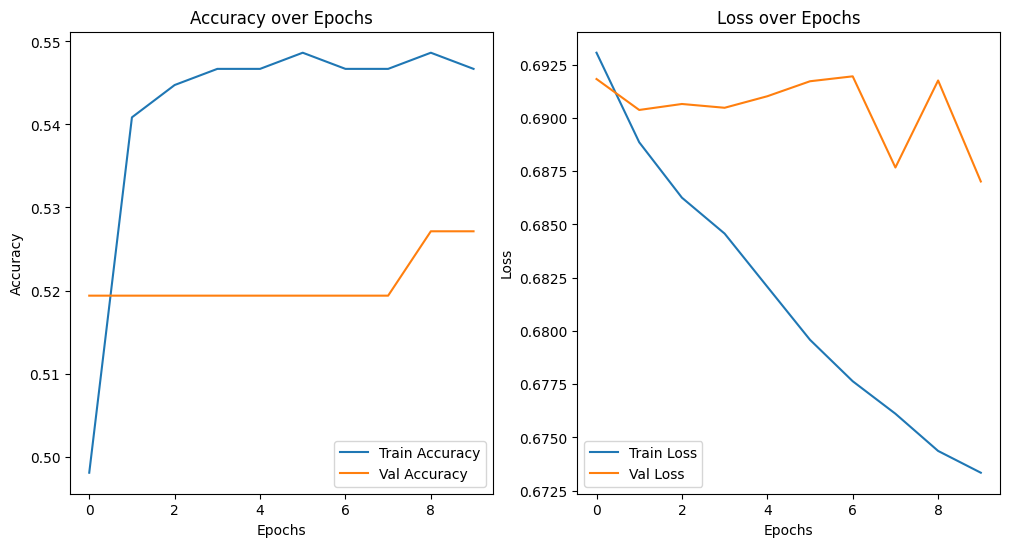

In [14]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()